for all preprocessing needs up until model dev


In [28]:
from pathlib import Path
import sys

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

from utils import helper_functions as hf


In [29]:
# Package import
import scipy.io
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.registration import phase_cross_correlation
import os
import time
import importlib
import torch
import torch.nn.functional as F
import glob
from scipy import signal
import random
import pickle


In [30]:
data_directory = r"C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo"
data_output_dir = r"C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo" # processed data output folder
SPLIT_MODE = 'acq' # Split mode acquistition-wise: 'acq' or middle split per acquisition: 'mid'
HIGH_PASS = 'nohp' # hp for application of highpass filter, nohp (or anything else) for no high pass application
TOP = 99 # top percentile clip (100 for no top clip)
BOTTOM = 1 # bottom percentile clip (0 for no bottom clip)

In [31]:


# cache_path = os.path.join(data_directory, "cached_datasets.pkl")

# Find all matching .mat files
mat_files = glob.glob(os.path.join(data_directory, "*.mat"))
if not mat_files:
    raise ValueError("No files starting with .mat found in the directory!")

print(f"Found {len(mat_files)} files to load...")

# Load all into memory
all_mat_data = {}
for mat_path in mat_files:
    base_name = os.path.splitext(os.path.basename(mat_path))[0]
    print(f"Loading {base_name}")
    all_mat_data[mat_path] = scipy.io.loadmat(mat_path)

print("✅ All .mat files loaded into memory.")

Found 70 files to load...


KeyboardInterrupt: 

In [ ]:
# Quick exploration helpers
sample_path = mat_files[0]
sample = all_mat_data[sample_path]

print("Sample file:", sample_path)
print("Keys:", [k for k in sample.keys() if not k.startswith('__')])

# Show shapes/dtypes for non-meta keys
summary = {}
for k, v in sample.items():
    if k.startswith('__'):
        continue
    summary[k] = (getattr(v, 'shape', None), getattr(v, 'dtype', None))
summary

# Preview 'Datas' if present
if 'Datas' in sample:
    datas = sample['Datas']
    print("Datas shape:", datas.shape, "dtype:", datas.dtype)
    # show one frame (adjust indexing if needed)
    frame = datas[:, :, 0] if datas.ndim == 3 else datas[..., 0]
    plt.imshow(np.log10(frame + 1e-8), cmap='viridis')
    plt.title("Datas preview (log10)")
    plt.colorbar()
    plt.show()
else:
    print("No 'Datas' key in this file.")

# Compare keys across files (helps spot Label_pauses vs Datas)
from collections import Counter
key_sets = [tuple(sorted(k for k in d.keys() if not k.startswith('__'))) for d in all_mat_data.values()]
print("Unique key sets:", Counter(key_sets))

Sample file: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo\Datas_Se01072020.mat
Keys: ['Data']
No 'Datas' key in this file.
Unique key sets: Counter({('Datas',): 36, ('Data',): 34})


Processing file 0: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo\Datas_Se01072020.mat
Available keys: ['Data']
<class 'numpy.ndarray'> float64 (128, 101, 7500)


Text(0.5, 1.0, 'Frame Acquisition 0 (Data)')

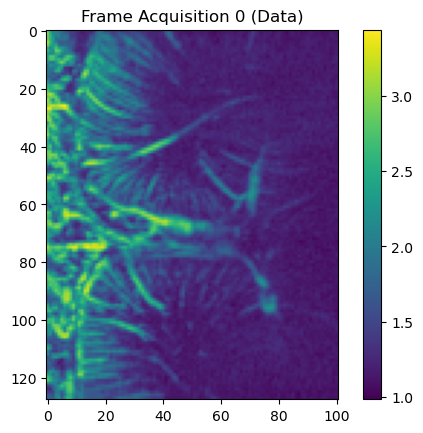

In [43]:
# Quick single-file preview (fast)
file_idx = 0

# Prefer already-loaded data if present; otherwise load one file from disk
if "all_mat_data" in globals() and len(all_mat_data) > 0:
    mat_path = list(all_mat_data.keys())[0]
    mat_data = all_mat_data[mat_path]
else:
    mat_files = glob.glob(os.path.join(data_directory, "*.mat"))
    if len(mat_files) == 0:
        raise ValueError("No .mat files found.")
    mat_path = mat_files[0]
    mat_data = scipy.io.loadmat(mat_path)

print(f"Processing file {file_idx}: {mat_path}")
print("Available keys:", [k for k in mat_data.keys() if not k.startswith('__')])

# Keep it simple: use Doppler if present, otherwise fall back to Datas
key = "Data" if "Data" in mat_data else "Datas"
if key not in mat_data:
    raise KeyError("Neither 'Data' nor 'Datas' found in this file.")
doppler_data = mat_data[key]
fus_struct = doppler_data['fus'][0, 0]   # struct with fields
frames = fus_struct['frame'][0, 0]       # actual numeric array

print(type(frames), frames.dtype, frames.shape)

frame0 = frames[:, :, 0] if frames.ndim == 3 else frames[..., 0]
plt.imshow(np.log10(frame0.astype(np.float32) + 1e-8), cmap='viridis')
plt.colorbar()
plt.title(f"Frame Acquisition {file_idx} ({key})")

# plt.close()

In [ ]:
all_images = []
all_labels = []
all_baselines = []
acquisition_indices_per_file = []  # Track cumulative starts for indices
current_frame_offset = 0
acquisition_indices = [] 
file_idx = 0  # Acquisition index (0 to len(mat_files)-1, only for kept files)

mat_files = list(all_mat_data.keys())
print(f"Found {len(mat_files)} preloaded files.")

for mat_path in mat_files:
    
    # Extract the data from the .mat files (might need to be adapted to new format)
    mat_data = all_mat_data[mat_path] 
    print(f"Processing file {file_idx}: {mat_path}")
    doppler_data = mat_data['Doppler']
    doppler_data = doppler_data[np.newaxis, :, :, :]

    images = np.transpose(doppler_data, (3, 0, 2, 1)).astype(np.float32)  # (N_images, 1, H_var, 128)
    images = np.log10(images)
    
    labels = mat_data['Label']
    labels_arr = np.array(labels).flatten().astype(np.int64)  # (N_labels,)
    
    # Shave 1 frames off end of images in case of mismatch between images and labels
    images, labels_arr = hf.mismatch(images, labels_arr)
    print(f"Raw images range: min={images.min():.6f}, max={images.max():.6f}")

    # Function that will pad or crop from the bottom/rightside of the image so it equals the target size
    images = hf.np_pad_or_crop_to_square(images, target_size=TARGET_SIZE)
    print(np.shape(images))

    # creation/loading of the roi_mask, if it does not find a mask "roi_{file_idx}.npy then it will ask you to create one"
    roi_mask = hf.get_or_create_roi_mask(images, file_idx)

    # Compute per acquisition baseline map
    baseline_idx = (labels_arr == -1)
    baseline_frames = images[baseline_idx] 
    images, _ = hf.pca_denoise(images.squeeze())

    # Take out baseline and compute CBV % change relative to baseline
    cbv_data, labels_arr = hf.delta_cbv_roi(images, labels_arr, roi_mask, use_log = False, robust = False)
    cbv_data *= roi_mask[None, :, :] # Ensure 0 outside of roi

doppler_data type: <class 'numpy.ndarray'> dtype: [('fus', 'O'), ('behaviour', 'O'), ('mask', 'O')] shape: (1, 1)
fus type: <class 'numpy.ndarray'>
fus dtype: object shape: (1,)
fus[0] type: <class 'numpy.ndarray'>
fus[0] dtype: [('frame', 'O'), ('time', 'O'), ('baseline_information', 'O')] shape: (1, 1)
